In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

class FitnessAgent:
    def __init__(self, num_actions, num_states=20000, alpha=0.1, gamma=0.95, epsilon=0.1, epsilon_decay=0.99, min_epsilon=0.01, batch_size=32, memory_size=2000):
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.q_table = np.zeros((num_states, num_actions))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        state_index = self.encode_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_table[state_index])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_index = self.encode_state(state)
            next_state_index = self.encode_state(next_state)
            target = reward
            if not done:
                target += self.gamma * np.max(self.q_table[next_state_index])
            td_error = target - self.q_table[state_index][action]
            self.q_table[state_index][action] += self.alpha * td_error
        self.reduce_epsilon()

    def reduce_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def encode_state(self, state):
        workout, sessions_remaining, total_duration, difficulty, progress = state
        difficulty_code = {'facile': 0, 'intermediaire': 1, 'difficile': 2}[difficulty]
        state_index = (sessions_remaining * 1000) + (total_duration * 10) + (difficulty_code * 100) + (progress // 10)
        return state_index

class TrainingEnvironment:
    def __init__(self, total_duration, exercise_params, difficulty='facile'):
        self.total_duration = total_duration
        self.exercise_params = exercise_params
        self.current_time = 0
        self.difficulty = difficulty
        self.sessions_remaining = 10
        self.current_workout = self.initialize_workout(difficulty)

    def initialize_workout(self, difficulty):
        return [
            {'exercise': 'Jumping Jack', 'reps': self.exercise_params[difficulty]['Jumping Jack']},
            {'exercise': 'Situps', 'reps': self.exercise_params[difficulty]['Situps']},
            {'exercise': 'Superman', 'reps': self.exercise_params[difficulty]['Superman']},
            {'exercise': 'High Knees', 'reps': self.exercise_params[difficulty]['High Knees']},
            {'exercise': 'Skipping Rope', 'reps': self.exercise_params[difficulty]['Skipping Rope']},
            {'exercise': 'Plank', 'reps': self.exercise_params[difficulty]['Plank']},
            {'exercise': 'Leg Raises', 'reps': self.exercise_params[difficulty]['Leg Raises']},
            {'exercise': 'Bicycle Crunches', 'reps': self.exercise_params[difficulty]['Bicycle Crunches']},
            {'exercise': 'Side Plank', 'reps': self.exercise_params[difficulty]['Side Plank']}
        ]

    def reset(self):
        self.current_time = 0
        self.sessions_remaining = 10
        self.current_workout = self.initialize_workout(self.difficulty)
        return self.get_state()

    def step(self, action):
        self.current_time += 1
        reward = self.calculate_reward()
        done = self.current_time >= self.total_duration or self.sessions_remaining <= 0
        self.sessions_remaining -= 1
        return self.get_state(), reward, done

    def calculate_reward(self):
        total_performance_ratio = 0
        for exercise in self.current_workout:
            exercise_name = exercise['exercise']
            target_reps = random.randint(exercise['reps'][0], exercise['reps'][1])
            completed_reps = random.randint(1, target_reps)
            performance_ratio = completed_reps / target_reps
            total_performance_ratio += performance_ratio
        return (total_performance_ratio / len(self.current_workout)) * 100

    def get_state(self):
        progress = int((self.current_time / self.total_duration) * 100)
        return (self.current_workout, self.sessions_remaining, self.total_duration, self.difficulty, progress)

    def apply_action_to_next_workout(self, action):
        if action == 0:
            pass  # No change
        elif 1 <= action <= 5:
            self.total_duration += action  # Increase duration
        elif 6 <= action <= 10:
            self.total_duration = max(1, self.total_duration - (action - 5))  # Decrease duration, minimum 1 minute
        elif action == 11:
            self.difficulty = 'intermediaire' if self.difficulty == 'facile' else 'difficile'
        elif action == 12:
            self.difficulty = 'facile' if self.difficulty == 'intermediaire' else 'intermediaire'
        self.current_workout = self.initialize_workout(self.difficulty)

def run_simulation(agent, environment, episodes):
    total_rewards = []
    actions_taken = []
    epsilons = []

    for episode in range(episodes):
        state = environment.reset()
        total_reward = 0
        done = False
        next_action = None
        while not done:
            action = agent.choose_action(state)
            next_action = action
            actions_taken.append(action)
            next_state, reward, done = environment.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        environment.apply_action_to_next_workout(next_action)
        agent.replay()

    return total_rewards, actions_taken, epsilons

# Setup parameters and run the simulation
exercise_params = {
    'facile': {
        'Jumping Jack': (10, 30),
        'Situps': (3, 8),
        'Superman': (2, 10),
        'High Knees': (20, 40),
        'Skipping Rope': (30, 60),
        'Plank': (15, 30),
        'Leg Raises': (5, 15),
        'Bicycle Crunches': (10, 20),
        'Side Plank': (10, 20)
    },
    'intermediaire': {
        'Jumping Jack': (30, 50),
        'Situps': (8, 14),
        'Superman': (10, 28),
        'High Knees': (40, 60),
        'Skipping Rope': (60, 90),
        'Plank': (30, 45),
        'Leg Raises': (15, 25),
        'Bicycle Crunches': (20, 30),
        'Side Plank': (20, 35)
    },
    'difficile': {
        'Jumping Jack': (50, 60),
        'Situps': (14, 28),
        'Superman': (30, 52),
        'High Knees': (60, 80),
        'Skipping Rope': (90, 120),
        'Plank': (45, 60),
        'Leg Raises': (25, 35),
        'Bicycle Crunches': (30, 50),
        'Side Plank': (35, 50)
    }
}

env = TrainingEnvironment(total_duration=20, exercise_params=exercise_params, difficulty='facile')
agent = FitnessAgent(num_actions=13, num_states=20000)
total_rewards, actions_taken, epsilons = run_simulation(agent, env, 20)

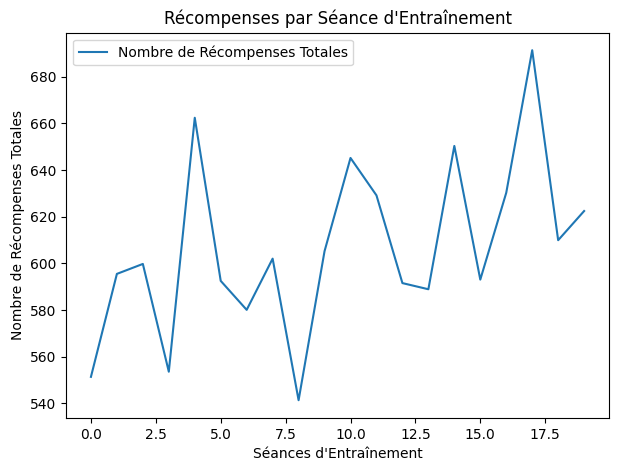

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(total_rewards, label='Nombre de Récompenses Totales')
plt.xlabel('Séances d\'Entraînement')
plt.ylabel('Nombre de Récompenses Totales')
plt.title('Récompenses par Séance d\'Entraînement')
plt.legend()
plt.show()


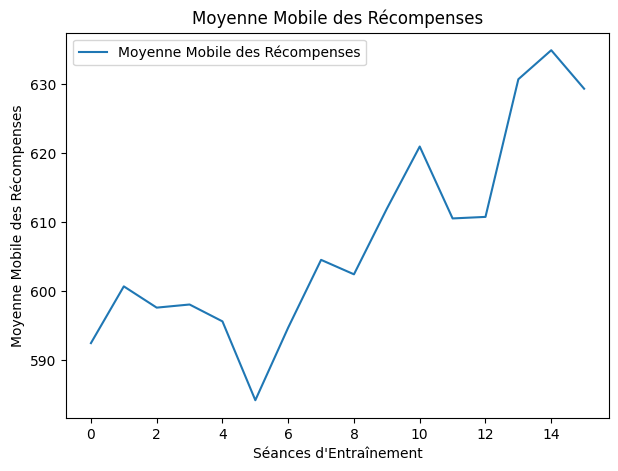

In [ ]:
plt.figure(figsize=(7, 5))
window_size = 5
moving_avg = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg, label='Moyenne Mobile des Récompenses')
plt.xlabel('Séances d\'Entraînement')
plt.ylabel('Moyenne Mobile des Récompenses')
plt.title('Moyenne Mobile des Récompenses')
plt.legend()
plt.show()


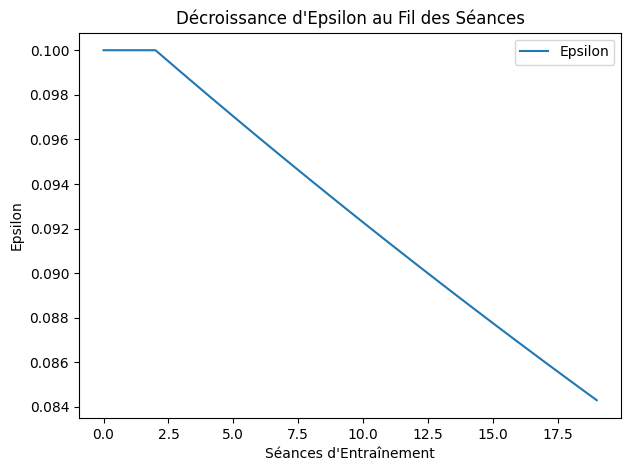

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(epsilons, label='Epsilon')
plt.xlabel('Séances d\'Entraînement')
plt.ylabel('Epsilon')
plt.title('Décroissance d\'Epsilon au Fil des Séances')
plt.legend()
plt.show()



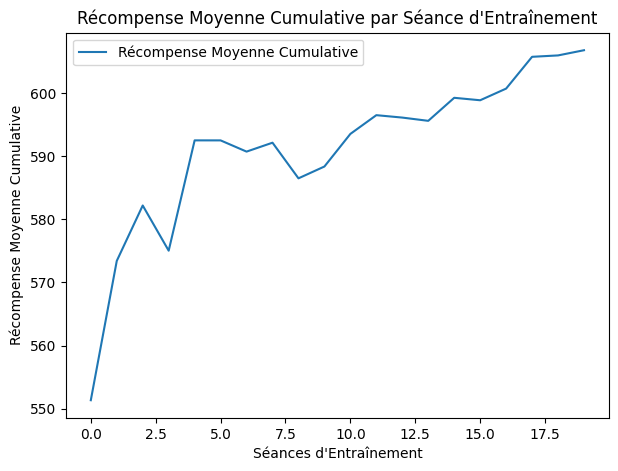

In [ ]:
plt.figure(figsize=(7, 5))
cumulative_avg_rewards = np.cumsum(total_rewards) / (np.arange(len(total_rewards)) + 1)
plt.plot(cumulative_avg_rewards, label='Récompense Moyenne Cumulative')
plt.xlabel('Séances d\'Entraînement')
plt.ylabel('Récompense Moyenne Cumulative')
plt.title('Récompense Moyenne Cumulative par Séance d\'Entraînement')
plt.legend()
plt.show()

